In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.datasets import VOCDetection

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32
num_epochs = 10
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
class_to_idx = {cls: idx for idx, cls in enumerate(VOC_CLASSES)}


train_dataset = VOCDetection(root='./data', year='2007', image_set='train', download=True, transform=transform)
val_dataset = VOCDetection(root='./data', year='2007', image_set='val', download=True, transform=transform)

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    labels = torch.zeros((len(targets), num_classes))
    for i, target in enumerate(targets):
        for obj in target['annotation']['object']:
            class_name = obj['name']
            if class_name in class_to_idx:
                labels[i, class_to_idx[class_name]] = 1
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

num_classes = 20
base_model = mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
base_model.classifier[1] = nn.Linear(base_model.last_channel, num_classes)
model = base_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds.int() == labels.int()).sum().item()
    return correct / labels.numel()


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {running_accuracy / len(train_loader):.4f}")

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    print(
        f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy / len(val_loader):.4f}")

torch.save(model.state_dict(), '/content/drive/MyDrive/nirs_dipl/mobilenet_pascalvoc_weights.pth')

# model.load_state_dict(torch.load('/content/drive/MyDrive/nirs_dipl/mobilenet_pascalvoc_weights.pth'))

100%|██████████| 460M/460M [00:17<00:00, 26.5MB/s]


Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 49.6MB/s]


Epoch [1/10], Loss: 0.1733, Accuracy: 0.9408
Validation Loss: 0.1158, Validation Accuracy: 0.9585
Epoch [2/10], Loss: 0.0980, Accuracy: 0.9645
Validation Loss: 0.1074, Validation Accuracy: 0.9621
Epoch [3/10], Loss: 0.0744, Accuracy: 0.9731
Validation Loss: 0.1187, Validation Accuracy: 0.9592
Epoch [4/10], Loss: 0.0591, Accuracy: 0.9781
Validation Loss: 0.1237, Validation Accuracy: 0.9584
Epoch [5/10], Loss: 0.0434, Accuracy: 0.9844
Validation Loss: 0.1323, Validation Accuracy: 0.9555
Epoch [6/10], Loss: 0.0384, Accuracy: 0.9867
Validation Loss: 0.1352, Validation Accuracy: 0.9567
Epoch [7/10], Loss: 0.0338, Accuracy: 0.9881
Validation Loss: 0.1361, Validation Accuracy: 0.9588
Epoch [8/10], Loss: 0.0303, Accuracy: 0.9897
Validation Loss: 0.1450, Validation Accuracy: 0.9578
Epoch [9/10], Loss: 0.0307, Accuracy: 0.9892
Validation Loss: 0.1325, Validation Accuracy: 0.9584
Epoch [10/10], Loss: 0.0214, Accuracy: 0.9929
Validation Loss: 0.1397, Validation Accuracy: 0.9597


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.datasets import VOCDetection

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32
num_epochs = 10
learning_rate = 0.001
masked_percent = 30


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
class_to_idx = {cls: idx for idx, cls in enumerate(VOC_CLASSES)}

train_dataset = VOCDetection(root='./data', year='2007', image_set='train', download=True, transform=transform)
val_dataset = VOCDetection(root='./data', year='2007', image_set='val', download=True, transform=transform)

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    labels = torch.zeros((len(targets), num_classes))
    for i, target in enumerate(targets):
        for obj in target['annotation']['object']:
            class_name = obj['name']
            if class_name in class_to_idx:
                labels[i, class_to_idx[class_name]] = 1
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

num_classes = len(VOC_CLASSES)

base_model = mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
base_model.classifier[1] = nn.Linear(base_model.last_channel, num_classes)
model = base_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds.int() == labels.int()).sum().item()
    return correct / labels.numel()

def apply_mask(data):
    mask = (torch.rand(data.size(), device=data.device) > masked_percent / 100).float()
    return data * mask

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        masked_images = apply_mask(images)

        optimizer.zero_grad()
        outputs = model(masked_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {running_accuracy / len(train_loader):.4f}")

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    print(
        f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy / len(val_loader):.4f}")

torch.save(model.state_dict(), '/content/drive/MyDrive/nirs_dipl/mobilenet_pascalvoc_weights_masked.pth')

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Epoch [1/10], Loss: 0.2232, Accuracy: 0.9260
Validation Loss: 0.2017, Validation Accuracy: 0.9339
Epoch [2/10], Loss: 0.1617, Accuracy: 0.9410
Validation Loss: 0.2100, Validation Accuracy: 0.9334
Epoch [3/10], Loss: 0.1395, Accuracy: 0.9482
Validation Loss: 0.1925, Validation Accuracy: 0.9341
Epoch [4/10], Loss: 0.1218, Accuracy: 0.9543
Validation Loss: 0.2338, Validation Accuracy: 0.9271
Epoch [5/10], Loss: 0.1060, Accuracy: 0.9601
Validation Loss: 0.1954, Validation Accuracy: 0.9364
Epoch [6/10], Loss: 0.0903, Accuracy: 0.9658
Validation Loss: 0.2383, Validation Accuracy: 0.9360
Epoch [7/10], Loss: 0.0803, Accuracy: 0.9698
Validation Loss: 0.2072, Validation Accuracy: 0.9378
Epoch [8/10], Loss: 0.0674, Accuracy: 0.9752
Validation Loss

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.datasets import VOCDetection
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32
num_epochs = 100
learning_rate = 0.001
masked_percent = 30

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
class_to_idx = {cls: idx for idx, cls in enumerate(VOC_CLASSES)}

train_dataset = VOCDetection(root='./data', year='2007', image_set='train', download=True, transform=transform)
val_dataset = VOCDetection(root='./data', year='2007', image_set='val', download=True, transform=transform)

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    labels = torch.zeros((len(targets), num_classes))
    for i, target in enumerate(targets):
        for obj in target['annotation']['object']:
            class_name = obj['name']
            if class_name in class_to_idx:
                labels[i, class_to_idx[class_name]] = 1
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

num_classes = len(VOC_CLASSES)

#base_model = mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
base_model = mobilenet_v2(weights=None)
base_model.classifier[1] = nn.Linear(base_model.last_channel, num_classes)
model = base_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds.int() == labels.int()).sum().item()
    return correct / labels.numel()

def apply_mask(data):
    mask = (torch.rand(data.size(), device=data.device) > masked_percent / 100).float()
    return data * mask

def encrypt(data):
    data_np = data.cpu().numpy()

    encrypted_data = (data_np ** 5) + (0.3 * np.sin(data_np * 6 * np.pi)) + (0.3 * np.cos(data_np * 6 * np.pi)) + (
                0.2 * np.random.randn(*data_np.shape))

    encrypted_data = np.clip(encrypted_data, 0, 1)

    return torch.tensor(encrypted_data, dtype=torch.float32, device=data.device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        images = images.float()

        masked_images = apply_mask(images)
        encrypted_images = encrypt(masked_images)

        optimizer.zero_grad()
        outputs = model(encrypted_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {running_accuracy / len(train_loader):.4f}")

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            masked_images = apply_mask(images)
            encrypted_images = encrypt(masked_images)

            outputs = model(encrypted_images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    print(
        f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy / len(val_loader):.4f}")

torch.save(model.state_dict(), '/content/drive/MyDrive/nirs_dipl/mobilenet_pascalvoc_weights_masked_encrypted_{100epochs}.pth')

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Epoch [1/100], Loss: 0.2694, Accuracy: 0.9126
Validation Loss: 0.2494, Validation Accuracy: 0.9220
Epoch [2/100], Loss: 0.2474, Accuracy: 0.9194
Validation Loss: 0.2535, Validation Accuracy: 0.9198
Epoch [3/100], Loss: 0.2439, Accuracy: 0.9188
Validation Loss: 0.2383, Validation Accuracy: 0.9212
Epoch [4/100], Loss: 0.2395, Accuracy: 0.9201
Validation Loss: 0.2486, Validation Accuracy: 0.9186
Epoch [5/100], Loss: 0.2378, Accuracy: 0.9195
Validation Loss: 0.2352, Validation Accuracy: 0.9204
Epoch [6/100], Loss: 0.2338, Accuracy: 0.9206
Validation Loss: 0.2375, Validation Accuracy: 0.9178
Epoch [7/100], Loss: 0.2303, Accuracy: 0.9212
Validation Loss: 0.2314, Validation Accuracy: 0.9213
Epoch [8/100], Loss: 0.2264, Accuracy: 0.9214
Validat

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader

# Установите устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
batch_size = 32

# Преобразования данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Загрузка валидационного набора данных Pascal VOC
val_dataset = VOCDetection(root='./data', year='2007', image_set='val', download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda x: tuple(zip(*x)))

# Загрузка предобученной модели MobileNetV2
model = mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
num_classes = 20  # Количество классов в Pascal VOC
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model.to(device)
model.eval()

# Функция для вычисления точности
def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds.int() == labels.int()).sum().item()
    return correct / labels.numel()

# Оценка модели на валидационном наборе данных
val_accuracy = 0.0

with torch.no_grad():
    for images, targets in val_loader:
        images = torch.stack([img.to(device) for img in images])
        labels = torch.zeros((len(targets), num_classes), device=device)

        for i, target in enumerate(targets):
            for obj in target['annotation']['object']:
                class_name = obj['name']
                if class_name in class_to_idx:
                    labels[i, class_to_idx[class_name]] = 1

        outputs = model(images)
        val_accuracy += calculate_accuracy(outputs, labels)

print(f"Validation Accuracy: {val_accuracy / len(val_loader):.4f}")

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


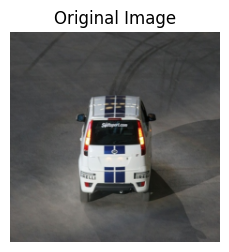

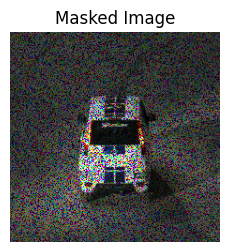

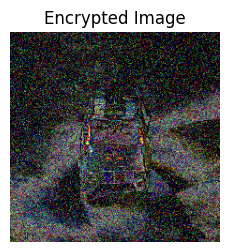

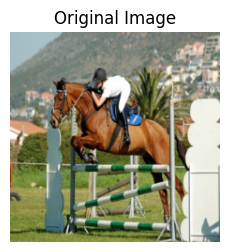

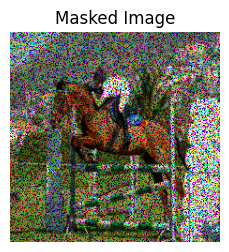

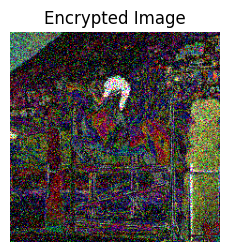

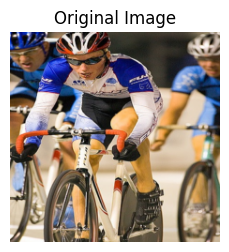

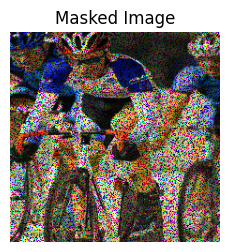

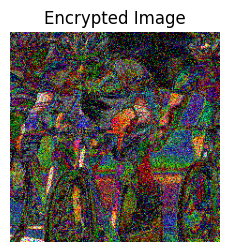

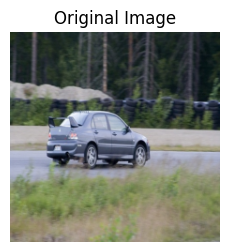

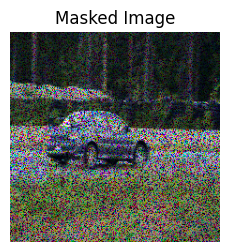

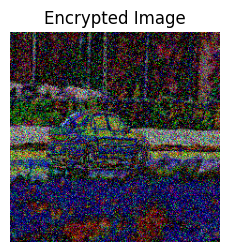

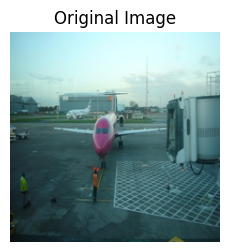

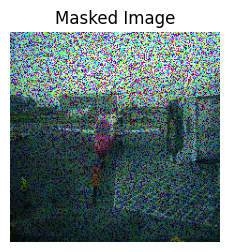

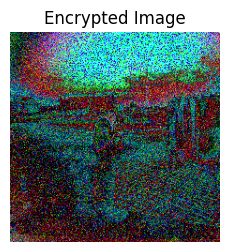

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

masked_percent = 30

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = VOCDetection(root='./data', year='2007', image_set='train', download=True, transform=transform)

def apply_mask(data):
    mask = (torch.rand(data.size(), device=data.device) > masked_percent / 100).float()
    return data * mask

def encrypt(data):
    data_np = data.cpu().numpy()

    # Apply encryption logic
    encrypted_data = (data_np ** 5) + (0.3 * np.sin(data_np * 6 * np.pi)) + (0.3 * np.cos(data_np * 6 * np.pi)) + (
                0.2 * np.random.randn(*data_np.shape))

    # Convert back to tensor and ensure it's float32 and on the correct device
    return torch.tensor(encrypted_data, dtype=torch.float32, device=data.device)

def show_images(images, title="Images"):
    """Display a batch of images."""
    plt.figure(figsize=(12, 6))
    for i in range(min(len(images), 6)):
        plt.subplot(2, 3, i + 1)
        # Check if the image has the correct number of dimensions
        if images[i].dim() == 3:  # Expected shape is (C, H, W)
            plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.title(title)
        else:
            print(f"Unexpected shape for image {i}: {images[i].shape}")
    plt.show()

num_examples = 5

for i in range(num_examples):
    original_image, _ = dataset[i]

    masked_image = apply_mask(original_image.unsqueeze(0))
    encrypted_image = encrypt(masked_image)

    show_images([original_image], title="Original Image")

    show_images([masked_image.squeeze(0)], title="Masked Image")

    # Ensure encrypted_image has the correct shape before displaying
    if encrypted_image.dim() == 4:  # Check if it's a batch dimension
        encrypted_image = encrypted_image.squeeze(0)  # Remove batch dimension if necessary

    show_images([encrypted_image], title="Encrypted Image")